# Preliminary cell type classification

----

In this notebook we provide a first outlook of the separability of the different cell types based on their nuclear morphology. To this end, we will use pre-existing data to train multiple models to distinguish various kinds of cell types.

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn import mixture
import itertools
from typing import List
from scipy import stats

from sklearn.model_selection import cross_val_score

from tqdm import tqdm

from scipy.stats import describe, kruskal

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def preprocess_data(
    data,
    corr_threshold: float = 0.8,
    exclude_columns: List = None,
    exclude_proteins: List = None,
):
    # Remove constant features for control data
    cleaned_data = data.loc[:, (data != data.iloc[0]).any()]
    cleaned_data = cleaned_data.dropna(axis=1, how="any")
    # Remove rows with missing entries in the control data
    cleaned_data = cleaned_data.dropna(axis=0)

    # Maintain features that have at most a Pearson correlation of corr_threshold
    data_corr_matrix = cleaned_data.corr().abs()
    upper = data_corr_matrix.where(
        np.triu(np.ones(data_corr_matrix.shape), k=1).astype(bool)
    )
    to_drop = [
        column for column in upper.columns if any(upper[column] > corr_threshold)
    ]
    if exclude_columns is not None:
        to_drop += list(set(exclude_columns).intersection(set(cleaned_data.columns)))
    if exclude_proteins is not None:
        for protein in exclude_proteins:
            for col in cleaned_data.columns:
                if protein in col:
                    to_drop.append(col)
    cleaned_data = cleaned_data.drop(to_drop, axis=1)

    return cleaned_data

<IPython.core.display.Javascript object>

In [3]:
def plot_tsne_visualization(data, labels, figsize: List = [12, 10]):
    random.seed(1234)
    tsne = TSNE(n_components=2, random_state=1234)
    embs = tsne.fit_transform(data)

    sns.set(style="darkgrid")

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    x = embs[:, 0]
    y = embs[:, 1]
    sns.scatterplot(x, y, hue=labels)
    ax.set_xlabel("tsne-1")
    ax.set_ylabel("tsne-2")
    plt.show()

<IPython.core.display.Javascript object>

In [4]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

<IPython.core.display.Javascript object>

In [69]:
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.head(20)
    # Define size of bar plot
    plt.figure(figsize=(8, 6))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Add chart labels
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    plt.show()

<IPython.core.display.Javascript object>

## 1. Read in data

 At the time being the available data is incomplete and thus we can only provide an preliminary analyses.

The existing data sets allow for the identification of 
* CD4 positive Tcells (with polylysine coating)
* CD8 positive Tcells (with fibronectin coating)
* CD45 positive PBMC (with fibronectin coating).

Since, we have seen before that the coating greatly affects the nuclear morphology and chromatin organization features, we will formulate two different classification problems:
1. CD4 positive Tcells vs other
2. CD45 positive PBMC cells vs other
3. CD8 positive Tcells vs other,

where other here defines a set of PBMCs that we cannot be identified with the current datasets.

During data preprocessing labels were derived for each individual cell in the different datasets using the corresponding marker-staining of those. In fact, the cellular expression of the respective marker protein as quantified by 

$$
e_i^p = \frac{\sum\limits_{\textrm{dilated nuclear mask}} I_i^p(\cdot)}{\textrm{dilated nuclear mask volume}}
$$

where the dilation was done such that we expand the nuclear mask by 10 pixels in each direction which translates to roughly one micron as we found the staining of the marker proteins on the cell surface to be a little bit less than 1 micron from the closest nuclear boundary.

To obtain a binary label to mark the ones positive for the marker-protein we fit two Gaussians to the distribution of the previously described quantity manually ensuring that the model's classification is based on a single cut-off value for which all cells with a larger marker expression are considered positive and the others negative. This labeling approach was applied to the biological samples individually at the time being to account for potentially different base expression of the marker proteins in the different biological samples.

We will now load all datasets and the respective labels.

---

### 1.1. Experiment 1: DAPI/CD8, FN coating (12bit)

In [5]:
hv1_dapi_cd8_file = "../../data/tcells_hv/dapi_cd8/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_cd8_features = pd.read_csv(hv1_dapi_cd8_file, index_col=0)
hv1_dapi_cd8_features["sample"] = np.repeat("t_m24_fn_cd8", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["age"] = np.repeat("24", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["sex"] = np.repeat("m", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["coating"] = np.repeat("fibronectin", len(hv1_dapi_cd8_features))

hv2_dapi_cd8_file = "../../data/tcells_hv/dapi_cd8/HV2_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_cd8_features = pd.read_csv(hv2_dapi_cd8_file, index_col=0)
hv2_dapi_cd8_features["sample"] = np.repeat("t_m33_fn_cd8", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["age"] = np.repeat("33", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["sex"] = np.repeat("m", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["coating"] = np.repeat("fibronectin", len(hv2_dapi_cd8_features))

hv4_dapi_cd8_file = "../../data/tcells_hv/dapi_cd8/HV4_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_cd8_features = pd.read_csv(hv4_dapi_cd8_file, index_col=0)
hv4_dapi_cd8_features["sample"] = np.repeat("t_m60_fn_cd8", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["age"] = np.repeat("60", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["sex"] = np.repeat("m", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["coating"] = np.repeat("fibronectin", len(hv4_dapi_cd8_features))

<IPython.core.display.Javascript object>

In [6]:
dapi_cd8_features = hv1_dapi_cd8_features.append(hv2_dapi_cd8_features).append(
    hv4_dapi_cd8_features
)
dapi_cd8_features = dapi_cd8_features[~dapi_cd8_features.index.duplicated(keep="first")]
dapi_cd8_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_cd8_3d_int,kurtosis_cd8_3d_int,skewness_cd8_3d_int,normalized_mean_cd8_3d_int,normalized_std_cd8_3d_int,normalized_q25_cd8_3d_int,normalized_q75_cd8_3d_int,normalized_median_cd8_3d_int,normalized_kurtosis_cd8_3d_int,normalized_skewness_cd8_3d_int
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.026255,0.048052,56.182500,0.132162,0.054812,0.049785,0.025431,7.224959,131.795000,0.128443,...,469.620000,5.734629,1.184775,2.890644,1.520579,0.054355,3.111887,2.698447,5.734629,1.184775
std,0.002349,0.015014,13.195245,0.045746,0.010061,0.011952,0.007475,1.556319,13.066745,0.065306,...,434.905586,21.801995,1.342489,0.252380,0.264681,0.158730,0.357186,0.333204,21.801992,1.342489
min,0.012771,0.024642,32.000000,0.076800,0.039975,0.036495,0.015854,5.409768,92.000000,0.033706,...,56.000000,-1.502947,-0.059957,1.247551,1.011046,0.000000,0.833679,0.708628,-1.502947,-0.059957
25%,0.025199,0.036639,49.000000,0.106286,0.048245,0.037563,0.020577,6.203779,124.000000,0.075943,...,159.000000,-0.204085,0.520202,2.790994,1.335952,0.000000,2.984532,2.568049,-0.204085,0.520202
50%,0.026368,0.045969,55.000000,0.125562,0.053561,0.047379,0.024296,6.873600,130.000000,0.118880,...,240.000000,0.980296,0.824756,2.928112,1.504918,0.000000,3.196701,2.774770,0.980296,0.824757
75%,0.027568,0.057226,61.000000,0.139167,0.059133,0.058785,0.028145,7.766070,137.000000,0.170225,...,756.500000,3.656804,1.321621,3.047314,1.651194,0.000000,3.322393,2.901958,3.656804,1.321621
max,0.032936,0.160003,214.000000,0.585786,0.166537,0.168743,0.098780,22.640772,214.000000,0.472136,...,2713.500000,323.895849,12.758441,3.471515,3.185819,0.864297,4.291959,3.336971,323.895811,12.758438


<IPython.core.display.Javascript object>

In [7]:
hv1_dapi_cd8_file = "../../data/tcells_hv/dapi_cd8/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv1_dapi_cd8_labels = pd.read_csv(hv1_dapi_cd8_file, index_col=0)

hv2_dapi_cd8_file = "../../data/tcells_hv/dapi_cd8/HV2_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv2_dapi_cd8_labels = pd.read_csv(hv2_dapi_cd8_file, index_col=0)

hv4_dapi_cd8_file = "../../data/tcells_hv/dapi_cd8/HV4_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv4_dapi_cd8_labels = pd.read_csv(hv4_dapi_cd8_file, index_col=0)

<IPython.core.display.Javascript object>

In [8]:
dapi_cd8_labels = hv1_dapi_cd8_labels.append(hv2_dapi_cd8_labels).append(
    hv4_dapi_cd8_labels
)
dapi_cd8_labels = dapi_cd8_labels[~dapi_cd8_labels.index.duplicated(keep="first")]
dapi_cd8_labels.head()

,cd8
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_0,0
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_1,1
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_2,1
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_3,1
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_4,1


<IPython.core.display.Javascript object>

---

### 1.2. Experiment 1: DAPI/CD4, polyL coating (16bit)

In [9]:
hv1_dapi_cd4_file = "../../data/tcells_hv/marker/HV1_Tcells_DAPI_CD4_08_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_cd4_features = pd.read_csv(hv1_dapi_cd4_file, index_col=0)
hv1_dapi_cd4_features["sample"] = np.repeat("t_m24_fn_cd4", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["age"] = np.repeat("24", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["sex"] = np.repeat("m", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["coating"] = np.repeat("polyL", len(hv1_dapi_cd4_features))

hv2_dapi_cd4_file = "../../data/tcells_hv/marker/HV2_Tcells_DAPI_CD4_08_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_cd4_features = pd.read_csv(hv2_dapi_cd4_file, index_col=0)
hv2_dapi_cd4_features["sample"] = np.repeat("t_m33_pl_cd4", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["age"] = np.repeat("33", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["sex"] = np.repeat("m", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["coating"] = np.repeat("polyL", len(hv2_dapi_cd4_features))

hv3_dapi_cd4_file = "../../data/tcells_hv/marker/HV3_Tcells_DAPI_CD4_09_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv3_dapi_cd4_features = pd.read_csv(hv3_dapi_cd4_file, index_col=0)
hv3_dapi_cd4_features["sample"] = np.repeat("t_f42_pl_cd4", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["age"] = np.repeat("42", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["sex"] = np.repeat("f", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["coating"] = np.repeat("polyL", len(hv3_dapi_cd4_features))

hv4_dapi_cd4_file = "../../data/tcells_hv/marker/HV3_Tcells_DAPI_CD4_09_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_cd4_features = pd.read_csv(hv4_dapi_cd4_file, index_col=0)
hv4_dapi_cd4_features["sample"] = np.repeat("t_m60_pl_cd4", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["age"] = np.repeat("60", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["sex"] = np.repeat("m", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["coating"] = np.repeat("fibronectin", len(hv4_dapi_cd4_features))

<IPython.core.display.Javascript object>

In [10]:
dapi_cd4_features = (
    hv1_dapi_cd4_features.append(hv2_dapi_cd4_features)
    .append(hv3_dapi_cd4_features)
    .append(hv4_dapi_cd4_features)
)
dapi_cd4_features = dapi_cd4_features[~dapi_cd4_features.index.duplicated(keep="first")]
dapi_cd4_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,normalized_mean_cd4_3d_int,normalized_std_cd4_3d_int,normalized_q25_cd4_3d_int,normalized_q75_cd4_3d_int,normalized_median_cd4_3d_int,normalized_kurtosis_cd4_3d_int,normalized_skewness_cd4_3d_int
count,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,...,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000,4478.000000
mean,0.028132,0.048957,52.366682,0.137332,0.056652,0.051284,0.026617,7.017212,123.877847,0.131454,...,6822.698079,6.322872,0.987849,3.122947,1.601381,0.055356,3.605409,3.221281,6.322872,0.987849
std,0.002396,0.015527,11.366652,0.049453,0.011255,0.011949,0.008545,1.622497,11.124573,0.063990,...,4329.938838,21.576431,1.300185,0.188694,0.244799,0.138914,0.340551,0.328997,21.576431,1.300185
min,0.000326,0.022358,25.000000,0.075943,0.039577,0.036495,0.014370,5.252014,59.000000,0.033706,...,2700.000000,-1.784775,-0.484509,1.718603,0.999161,0.000000,1.219777,0.698884,-1.784775,-0.484509
25%,0.027170,0.039214,46.000000,0.112288,0.050881,0.041743,0.022131,6.206846,118.000000,0.086867,...,4814.250000,-0.809362,0.453293,3.039082,1.437931,0.000000,3.393300,3.041658,-0.809361,0.453293
50%,0.028226,0.046261,51.000000,0.128911,0.054643,0.047379,0.024959,6.675573,123.000000,0.125562,...,5936.250000,-0.174984,0.564242,3.143126,1.597259,0.000000,3.573793,3.212093,-0.174984,0.564242
75%,0.029229,0.055172,57.000000,0.149234,0.059605,0.058785,0.028672,7.332540,129.000000,0.165129,...,7982.750000,1.696443,0.821700,3.243186,1.712128,0.000000,3.835032,3.447887,1.696443,0.821700
max,0.070115,0.182444,235.000000,0.585786,0.207496,0.205785,0.103573,30.523842,280.000000,0.500000,...,53845.500000,228.416149,12.149275,4.283891,3.300441,1.673660,6.196594,5.344963,228.416137,12.149274


<IPython.core.display.Javascript object>

In [11]:
hv1_dapi_cd4_file = "../../data/tcells_hv/marker/HV1_Tcells_DAPI_CD4_08_07_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv1_dapi_cd4_labels = pd.read_csv(hv1_dapi_cd4_file, index_col=0)

hv2_dapi_cd4_file = "../../data/tcells_hv/marker/HV2_Tcells_DAPI_CD4_08_07_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv2_dapi_cd4_labels = pd.read_csv(hv2_dapi_cd4_file, index_col=0)

hv3_dapi_cd4_file = "../../data/tcells_hv/marker/HV3_Tcells_DAPI_CD4_09_07_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv3_dapi_cd4_labels = pd.read_csv(hv3_dapi_cd4_file, index_col=0)

hv4_dapi_cd4_file = "../../data/tcells_hv/marker/HV4_Tcells_DAPI_CD4_09_07_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv4_dapi_cd4_labels = pd.read_csv(hv4_dapi_cd4_file, index_col=0)

<IPython.core.display.Javascript object>

In [12]:
dapi_cd4_labels = (
    hv1_dapi_cd4_labels.append(hv2_dapi_cd4_labels)
    .append(hv3_dapi_cd4_labels)
    .append(hv4_dapi_cd4_labels)
)
dapi_cd4_labels = dapi_cd4_labels[~dapi_cd4_labels.index.duplicated(keep="first")]
dapi_cd4_labels.head()

,cd4
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_0,1
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_1,1
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_2,1
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_3,1
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_4,0


<IPython.core.display.Javascript object>

---

### 1.1. Experiment 1: DAPI/CD45 (16bit)

In [13]:
hv1_dapi_cd45_file = "../../data/pbmc_hv/marker/HV1_PBMC_DAPI_CD45_16_6_21_16bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_cd45_features = pd.read_csv(hv1_dapi_cd45_file, index_col=0)
hv1_dapi_cd45_features["sample"] = np.repeat(
    "t_m24_fn_cd45", len(hv1_dapi_cd45_features)
)
hv1_dapi_cd45_features["age"] = np.repeat("24", len(hv1_dapi_cd45_features))
hv1_dapi_cd45_features["sex"] = np.repeat("m", len(hv1_dapi_cd45_features))
hv1_dapi_cd45_features["coating"] = np.repeat(
    "fibronectin", len(hv1_dapi_cd45_features)
)

hv2_dapi_cd45_file = "../../data/pbmc_hv/marker/HV2_PBMC_DAPI_CD45_24_6_21_16bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_cd45_features = pd.read_csv(hv2_dapi_cd45_file, index_col=0)
hv2_dapi_cd45_features["sample"] = np.repeat(
    "t_m33_fn_cd45", len(hv2_dapi_cd45_features)
)
hv2_dapi_cd45_features["age"] = np.repeat("33", len(hv2_dapi_cd45_features))
hv2_dapi_cd45_features["sex"] = np.repeat("m", len(hv2_dapi_cd45_features))
hv2_dapi_cd45_features["coating"] = np.repeat(
    "fibronectin", len(hv2_dapi_cd45_features)
)

hv4_dapi_cd45_file = "../../data/pbmc_hv/marker/HV4_PBMC_DAPI_CD45_24_6_21_16bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_cd45_features = pd.read_csv(hv4_dapi_cd45_file, index_col=0)
hv4_dapi_cd45_features["sample"] = np.repeat(
    "t_m60_fn_cd45", len(hv4_dapi_cd45_features)
)
hv4_dapi_cd45_features["age"] = np.repeat("60", len(hv4_dapi_cd45_features))
hv4_dapi_cd45_features["sex"] = np.repeat("m", len(hv4_dapi_cd45_features))
hv4_dapi_cd45_features["coating"] = np.repeat(
    "fibronectin", len(hv4_dapi_cd45_features)
)

<IPython.core.display.Javascript object>

In [14]:
dapi_cd45_features = hv1_dapi_cd45_features.append(hv2_dapi_cd45_features).append(
    hv4_dapi_cd45_features
)
dapi_cd45_features = dapi_cd45_features[
    ~dapi_cd45_features.index.duplicated(keep="first")
]
dapi_cd45_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_cd45_3d_int,kurtosis_cd45_3d_int,skewness_cd45_3d_int,normalized_mean_cd45_3d_int,normalized_std_cd45_3d_int,normalized_q25_cd45_3d_int,normalized_q75_cd45_3d_int,normalized_median_cd45_3d_int,normalized_kurtosis_cd45_3d_int,normalized_skewness_cd45_3d_int
count,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,...,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000
mean,0.026922,0.055176,54.299113,0.148214,0.059853,0.055071,0.028853,7.839695,130.631179,0.154858,...,9353.171736,17.166585,1.773742,2.889214,1.646071,0.040520,3.332958,3.025494,17.166585,1.773742
std,0.003778,0.019061,19.121022,0.065988,0.014571,0.014257,0.011233,2.417170,19.431373,0.072482,...,15496.560158,41.551197,2.364928,0.422083,0.447800,0.120339,0.660771,0.621697,41.551196,2.364928
min,-0.001781,0.026266,26.000000,0.076800,0.041609,0.036495,0.015284,5.275396,74.000000,0.033706,...,913.000000,-1.852287,-1.104467,0.890293,0.127370,0.000000,0.527668,0.477568,-1.852287,-1.104468
25%,0.025443,0.043922,45.000000,0.116547,0.052635,0.047379,0.023055,6.568133,121.000000,0.103945,...,2061.000000,-0.926059,0.429028,2.784100,1.361176,0.000000,3.097602,2.818125,-0.926059,0.429028
50%,0.027188,0.051833,51.000000,0.128911,0.057023,0.054669,0.026264,7.196404,128.000000,0.145756,...,2779.000000,2.495559,0.942387,2.970510,1.664485,0.000000,3.461132,3.167281,2.495558,0.942386
75%,0.028645,0.062824,58.000000,0.153825,0.063238,0.058785,0.030326,8.361316,135.000000,0.188638,...,4982.000000,15.965658,2.220875,3.111719,1.864890,0.000000,3.720124,3.393841,15.965655,2.220874
max,0.066747,0.174742,239.000000,0.585786,0.184714,0.174150,0.107856,29.973504,280.000000,0.472136,...,65535.000000,420.599640,17.563793,4.807116,3.404287,1.228148,5.283892,4.886009,420.599534,17.563795


<IPython.core.display.Javascript object>

In [15]:
hv1_dapi_cd45_file = "../../data/pbmc_hv/marker/HV1_PBMC_DAPI_CD45_16_6_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv1_dapi_cd45_labels = pd.read_csv(hv1_dapi_cd45_file, index_col=0)

hv2_dapi_cd45_file = "../../data/pbmc_hv/marker/HV2_PBMC_DAPI_CD45_24_6_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv2_dapi_cd45_labels = pd.read_csv(hv2_dapi_cd45_file, index_col=0)

hv4_dapi_cd45_file = "../../data/pbmc_hv/marker/HV4_PBMC_DAPI_CD45_24_6_21_16bit/preprocessed/ia/marker_labels/marker_labels.csv"
hv4_dapi_cd45_labels = pd.read_csv(hv4_dapi_cd45_file, index_col=0)

<IPython.core.display.Javascript object>

In [16]:
dapi_cd45_labels = hv1_dapi_cd45_labels.append(hv2_dapi_cd45_labels).append(
    hv4_dapi_cd45_labels
)
dapi_cd45_labels = dapi_cd45_labels[~dapi_cd45_labels.index.duplicated(keep="first")]
dapi_cd45_labels.head()

,cd45
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_0,0
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_1,0
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_2,1
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_3,1
PBMC_Dapi_CD45_16_6_21_2X_16bit_2_0,1


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Next, we preprocess the data in a standardized way that includes the following steps:
1. Filter out invariant features
2. Filter out features and columns with NAs
3. Filter out features that show a correlation of > 0.8 with other features
4. Normalize the data

In [17]:
sc = StandardScaler()

<IPython.core.display.Javascript object>

### 2.1. Experiment 1: DAPI/CD8, fibronectin (12bit)

In [18]:
processed_dapi_cd8_data = preprocess_data(
    dapi_cd8_features,
    corr_threshold=0.8,
    exclude_columns=[
        "label",
        "bbox-0",
        "bbox-1",
        "bbox-2",
        "label",
        "orientation",
        "age",
    ],
    exclude_proteins=["cd8"],
)
processed_dapi_cd8_features = processed_dapi_cd8_data.select_dtypes(include=np.number)
scaled_dapi_cd8_features = sc.fit_transform(processed_dapi_cd8_features)
dapi_cd8_labels_1 = dapi_cd8_labels.loc[processed_dapi_cd8_features.index]

<IPython.core.display.Javascript object>

### 2.2. Experiment 2: DAPI/CD4, poly-L (16bit)

In [19]:
processed_dapi_cd4_data = preprocess_data(
    dapi_cd4_features,
    corr_threshold=0.8,
    exclude_columns=[
        "label",
        "bbox-0",
        "bbox-1",
        "bbox-2",
        "label",
        "orientation",
        "age",
    ],
    exclude_proteins=["cd4"],
)
processed_dapi_cd4_features = processed_dapi_cd4_data.select_dtypes(include=np.number)
scaled_dapi_cd4_features = sc.fit_transform(processed_dapi_cd4_features)
dapi_cd4_labels = dapi_cd4_labels.loc[processed_dapi_cd4_features.index]

<IPython.core.display.Javascript object>

### 2.3. Experiment 3: DAPI/CD4, fibronectin (16bit)

In [20]:
processed_dapi_cd45_data = preprocess_data(
    dapi_cd45_features,
    corr_threshold=0.8,
    exclude_columns=[
        "label",
        "bbox-0",
        "bbox-1",
        "bbox-2",
        "label",
        "orientation",
        "age",
    ],
    exclude_proteins=["cd45"],
)
processed_dapi_cd45_features = processed_dapi_cd45_data.select_dtypes(include=np.number)
scaled_dapi_cd45_features = sc.fit_transform(processed_dapi_cd45_features)
dapi_cd45_labels = dapi_cd45_labels.loc[processed_dapi_cd45_features.index]

<IPython.core.display.Javascript object>

---

## 3. Data visualization

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


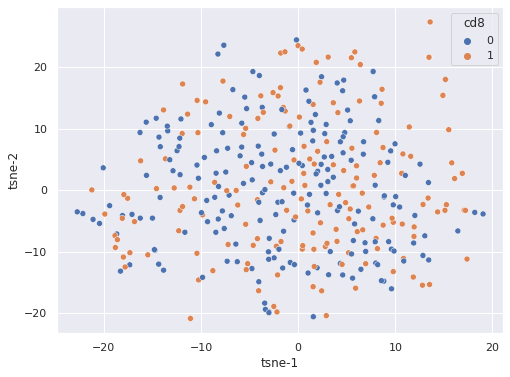

<IPython.core.display.Javascript object>

In [21]:
plot_tsne_visualization(
    data=scaled_dapi_cd8_features, labels=dapi_cd8_labels.iloc[:, 0], figsize=[8, 6]
)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


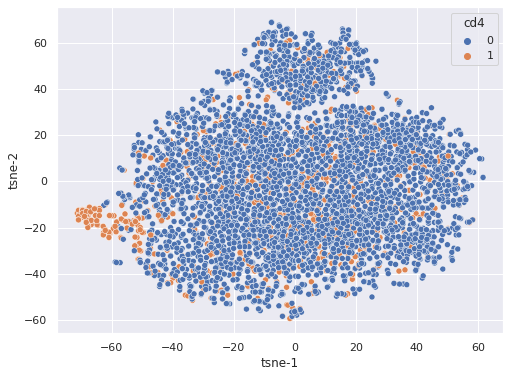

<IPython.core.display.Javascript object>

In [22]:
plot_tsne_visualization(
    data=scaled_dapi_cd4_features, labels=dapi_cd4_labels.iloc[:, 0], figsize=[8, 6]
)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


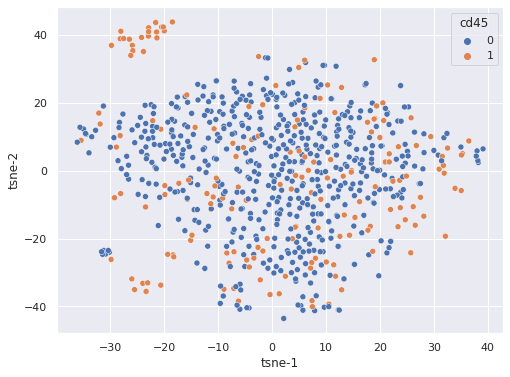

<IPython.core.display.Javascript object>

In [23]:
plot_tsne_visualization(
    data=scaled_dapi_cd45_features, labels=dapi_cd45_labels.iloc[:, 0], figsize=[8, 6]
)

---

## 4. Classification

After preprocessing the data, we will provide a preliminary estimate of the separability of the positive and negative cells for the individual marker using the nuclear and chromatin organization features in 2/3D. To this end, we will fit a RandomForest classifier on the data using a 10-fold stratified cross-validation approach and compute the ROC curve as well as the classification accuracy.

### 4.1. Experiment 1: DAPI/CD8, fibronectin (12bit)

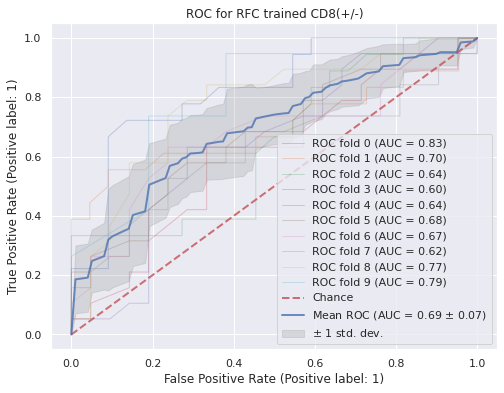

<IPython.core.display.Javascript object>

In [70]:
cd8_rfc = RFC(n_estimators=100, random_state=1234, n_jobs=5, class_weight="balanced")

_, _, cd8_rfc = plot_roc_for_stratified_cv(
    np.array(scaled_dapi_cd8_features),
    np.array(dapi_cd8_labels.iloc[:, 0]),
    10,
    cd8_rfc,
    "ROC for RFC trained CD8(+/-)",
)

In [71]:
cd8_cv_acc = cross_val_score(
    cd8_rfc,
    np.array(scaled_dapi_cd8_features),
    np.array(dapi_cd8_labels.iloc[:, 0]),
    cv=StratifiedKFold(10, random_state=1234, shuffle=True),
    scoring="accuracy",
)
print("CV scores:")
print(stats.describe(cd8_cv_acc))
cd8_sample_counter = Counter(dapi_cd8_labels.iloc[:, 0])
cd8_sample_counts = np.array(list(cd8_sample_counter.values())) / len(dapi_cd8_labels)
print(" ")
print("Sample frequencies:")
print(cd8_sample_counts)

CV scores:
DescribeResult(nobs=10, minmax=(0.6, 0.825), mean=0.6925, variance=0.005840277777777776, skewness=0.545163803353971, kurtosis=-0.9540564499823976)
 
Sample frequencies:
[0.5325 0.4675]


<IPython.core.display.Javascript object>

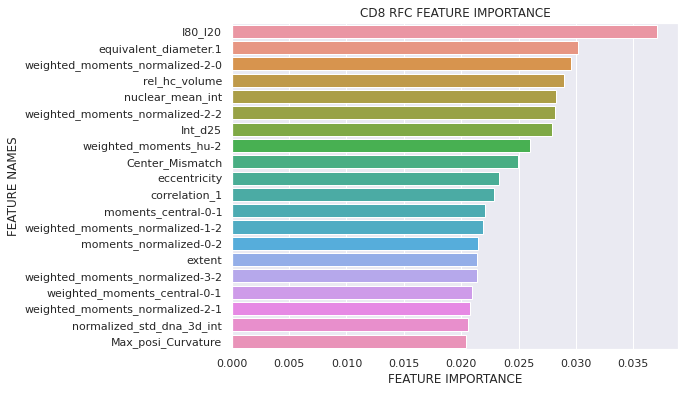

<IPython.core.display.Javascript object>

In [72]:
plot_feature_importance(
    cd8_rfc.feature_importances_, processed_dapi_cd8_features.columns, "CD8 RFC "
)

### 4.2. Experiment 2: DAPI/CD4, poly-L (16bit)

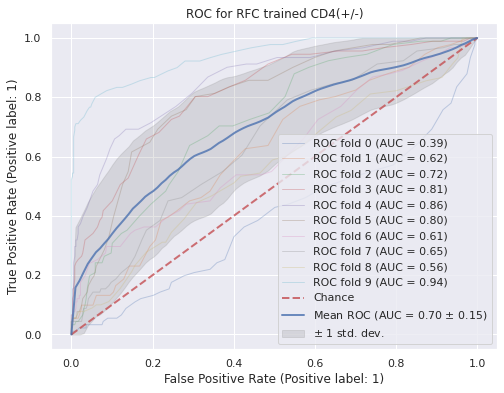

<IPython.core.display.Javascript object>

In [73]:
cd4_rfc = RFC(n_estimators=100, random_state=1234, n_jobs=5, class_weight="balanced")

_, _, cd4_rfc = plot_roc_for_stratified_cv(
    np.array(scaled_dapi_cd4_features),
    np.array(dapi_cd4_labels.iloc[:, 0]),
    10,
    cd4_rfc,
    "ROC for RFC trained CD4(+/-)",
)

In [74]:
cd4_cv_acc = cross_val_score(
    cd4_rfc,
    np.array(scaled_dapi_cd4_features),
    np.array(dapi_cd4_labels.iloc[:, 0]),
    cv=StratifiedKFold(10, random_state=1234, shuffle=True),
    scoring="accuracy",
)
print("CV scores:")
print(stats.describe(cd4_cv_acc))
cd4_sample_counter = Counter(dapi_cd4_labels.iloc[:, 0])
cd4_sample_counts = np.array(list(cd4_sample_counter.values())) / len(dapi_cd4_labels)
print(" ")
print("Sample frequencies:")
print(cd4_sample_counts)

CV scores:
DescribeResult(nobs=10, minmax=(0.8013392857142857, 0.8370535714285714), mean=0.8215733860658357, variance=0.00010962627711888322, skewness=-0.41989908689068833, kurtosis=-0.31664835589051865)
 
Sample frequencies:
[0.20276909 0.79723091]


<IPython.core.display.Javascript object>

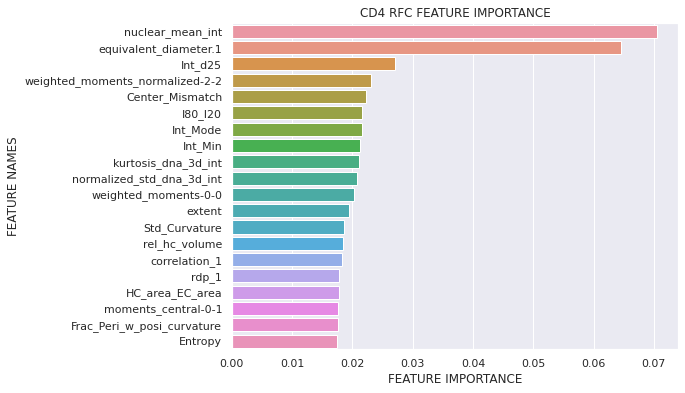

<IPython.core.display.Javascript object>

In [75]:
plot_feature_importance(
    cd4_rfc.feature_importances_, processed_dapi_cd4_features.columns, "CD4 RFC "
)

### 4.3. Experiment 3: DAPI/CD45, fibronectin (16bit)

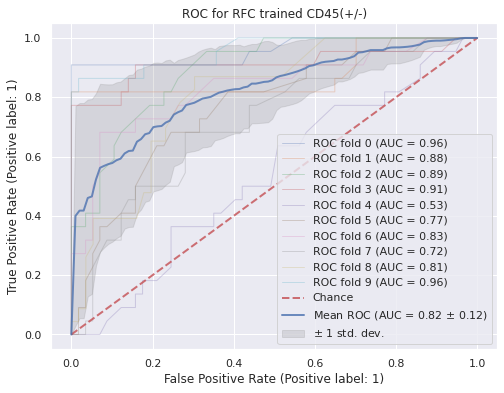

<IPython.core.display.Javascript object>

In [76]:
cd45_rfc = RFC(n_estimators=100, random_state=1234, n_jobs=5, class_weight="balanced")

_, _, cd45_rfc = plot_roc_for_stratified_cv(
    np.array(scaled_dapi_cd45_features),
    np.array(dapi_cd45_labels.iloc[:, 0]),
    10,
    cd45_rfc,
    "ROC for RFC trained CD45(+/-)",
)

In [77]:
cd45_cv_acc = cross_val_score(
    cd45_rfc,
    np.array(scaled_dapi_cd45_features),
    np.array(dapi_cd45_labels.iloc[:, 0]),
    cv=StratifiedKFold(10, random_state=1234, shuffle=True),
    scoring="accuracy",
)
print("CV scores:")
print(stats.describe(cd45_cv_acc))
cd45_sample_counter = Counter(dapi_cd45_labels.iloc[:, 0])
cd45_sample_counts = np.array(list(cd45_sample_counter.values())) / len(
    dapi_cd45_labels
)
print(" ")
print("Sample frequencies:")
print(cd45_sample_counts)

CV scores:
DescribeResult(nobs=10, minmax=(0.7974683544303798, 0.8860759493670886), mean=0.8339824732229795, variance=0.0007937267930119165, skewness=0.276769334367661, kurtosis=-0.6807837970156423)
 
Sample frequencies:
[0.71989861 0.28010139]


<IPython.core.display.Javascript object>

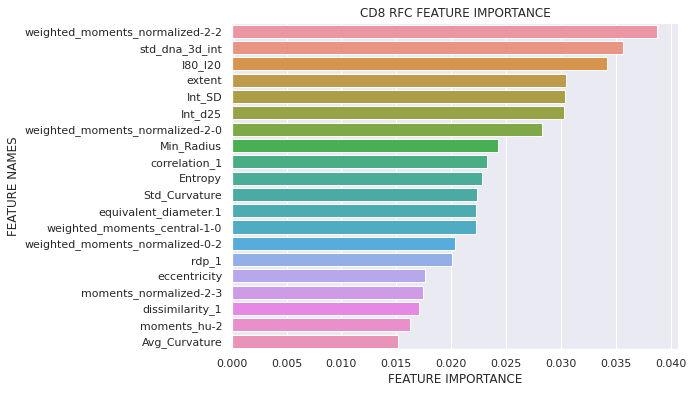

<IPython.core.display.Javascript object>

In [78]:
plot_feature_importance(
    cd45_rfc.feature_importances_, processed_dapi_cd45_features.columns, "CD8 RFC "
)

In summary, we see that we can distinguish between the different classes substantially better than chance. However, the performances are yet not that high. Additionally, the relative abundance of the classes in the ground truth data seems a little bit high for CD4 positive cells being up 80% of the relatively large data set. This might be due to the sampling (i.e. that images were taken preferentially of cells that show CD4 expression) or might indicate that the automatic labeling based on the GMM approach applied to the CD4 stain should be checked carefully.